## Mock up Coordinate grid

The below was run and uploaded to s3, such that the following section can now be run using the data corresponding to date 20180924

In [3]:
import numpy as np
import os
import glob
import json

def adjust_coordinates(directory, out_dir):
    
    os.makedirs(out_dir, exist_ok=True)
    
    # this was extracted from a conversation with @dganguli who determined 
    # the stitching order
    coordinates = np.array(
        [[1, 2, 3, 4],
         [8, 7, 6, 5],
         [9, 10, 11, 12],
         [16, 15, 14, 13]],
        dtype=int
    ) - 1  # 0 indexed
    

    # pseudo-distances, since the pixel size is not known, but the aspect 
    # ratio is 4 : 3
    x = 100
    y = 75

    # these coordinates set up a grid wherein the origin is the lower-left
    y_min = np.tile(np.arange(4)[:, None][::-1], 4) * y
    y_max = np.tile(np.arange(1, 5)[:, None][::-1], 4) * y
    x_min = np.tile(np.arange(4)[None, :][::-1], 4).reshape(4, 4) * x 
    x_max = np.tile(np.arange(1, 5)[None, :][::-1], 4).reshape(4, 4) * x
    
    # add coordinates to the existing data
    files = glob.glob(os.path.join(directory + '*fov*.json'))
    assert files
    for f in files:
        
        # get the json data
        with open(f, 'rb') as fhr:
            json_data = json.load(fhr)
        
        # find the coordinate index and then get corrected pseudo-coordinates
        index_pattern = '^.*?_(\d{3})\.json$'
        index = int(re.match(index_pattern, f).group(1))
        
        # construct coordinates dict
        j = np.where(coordinates == index)
        coords = {
            "x": [
                int(x_min[j]),
                int(x_max[j])
            ],
            "y": [
                int(y_min[j]),
                int(y_max[j])
            ],
            "z": [
                0.0,
                0.0001
            ]
        }
        
        # correct the coordinates
        for i, tile in enumerate(json_data['tiles']):
            json_data['tiles'][i]['coordinates'] = coords
        
        # write corrected data to out_dir
        filename = os.path.basename(f)
        outfile = os.path.join(out_dir, filename)
        with open(outfile, 'w') as fhw:
            json.dump(json_data, fhw)

In [72]:
adjust_coordinates('/Users/ajc/Desktop/iss_breast/', '/Users/ajc/Desktop/iss_coordinates')

## Create an ISS Pipeline

In [1]:
import starfish
from starfish.image import Filter, Registration, Segmentation
from starfish.spots import SpotFinder
from starfish.types import Indices, Features
import warnings


def iss_pipeline(fov, codebook): 
    
    primary_image = fov.primary_image
        
    print('Registering...')
    registration = Registration.FourierShiftRegistration(
        upsampling=1000,
        reference_stack=fov['dots']
    )
    registered = registration.run(primary_image, in_place=False)

    # filter raw data
    masking_radius = 15
    filt = Filter.WhiteTophat(masking_radius, is_volume=False)
    print('WhiteTophat Filtering...')
    filtered = filt.run(registered, verbose=True, in_place=False)

    
    min_sigma = 1
    max_sigma = 10
    num_sigma = 30
    threshold = 0.01

    print('Detecting spots...')
    p = SpotFinder.GaussianSpotDetector(
        min_sigma=1,
        max_sigma=10,
        num_sigma=30,
        threshold=0.01,
        measurement_type='mean',
    )

    # detect triggers some numpy warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # blobs = dots; define the spots in the dots image, but then find them again in the stack.
        blobs_image = fov['dots'].max_proj(Indices.ROUND, Indices.Z)
        intensities = p.run(filtered, blobs_image=blobs_image)
    
    print('Decoding...')
    decoded = codebook.decode_per_round_max(intensities)
    
    print('Segmenting...')
    seg = Segmentation.Watershed(
        dapi_threshold=.16,
        input_threshold=.22,
        min_distance=57,
    )
    regions = seg.run(primary_image, fov['nuclei'])
    
    return decoded, regions

In [2]:
def process_experiment(experiment: starfish.Experiment):
    decoded_intensities = {}
    regions = {}
    for name_, fov in experiment.items():
        decoded, segmentation_results = iss_pipeline(fov, experiment.codebook)
        decoded_intensities[name_] = decoded
        regions[name_] = segmentation_results

    return decoded_intensities, regions

In [3]:
experiment_metadata = 'http://czi.starfish.data.public.s3.amazonaws.com/browse/formatted/20180924/iss_breast/experiment.json'

In [4]:
exp = starfish.Experiment.from_json(experiment_metadata)
exp

<starfish.Experiment (FOVs=16)>
{
fov_000: <starfish.FieldOfView>
  Primary Image: <slicedimage._tileset.TileSet object at 0x1255b2c18>
  Auxiliary Images:
    nuclei: <slicedimage._tileset.TileSet object at 0x1266e7588>
    dots: <slicedimage._tileset.TileSet object at 0x1266f9588>
fov_001: <starfish.FieldOfView>
  Primary Image: <slicedimage._tileset.TileSet object at 0x12666e470>
  Auxiliary Images:
    nuclei: <slicedimage._tileset.TileSet object at 0x1266b2240>
    dots: <slicedimage._tileset.TileSet object at 0x1266f9438>
fov_002: <starfish.FieldOfView>
  Primary Image: <slicedimage._tileset.TileSet object at 0x1255b2668>
  Auxiliary Images:
    nuclei: <slicedimage._tileset.TileSet object at 0x1266e76d8>
    dots: <slicedimage._tileset.TileSet object at 0x1266f96a0>
fov_003: <starfish.FieldOfView>
  Primary Image: <slicedimage._tileset.TileSet object at 0x1255b2c50>
  Auxiliary Images:
    nuclei: <slicedimage._tileset.TileSet object at 0x1266e7748>
    dots: <slicedimage._tiles

In [5]:
decoded_intensities, regions = process_experiment(exp)

  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


For round: 0, Shift: [  5.764 -22.812], Error: 0.6056384146332833
For round: 1, Shift: [  1.857 -22.158], Error: 0.6367406189757153
For round: 2, Shift: [ -3.181 -21.871], Error: 0.6762645577802315
For round: 3, Shift: [ -4.343 -14.904], Error: 0.6818543622551125
WhiteTophat Filtering...


16it [00:06,  2.39it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


For round: 0, Shift: [ 3.065 -5.115], Error: 0.4898523193795024
For round: 1, Shift: [0.252 2.178], Error: 0.5625204205193758
For round: 2, Shift: [-2.807 -4.098], Error: 0.613845138434974
For round: 3, Shift: [-3.449 -0.095], Error: 0.6296494759997618
WhiteTophat Filtering...


16it [00:06,  2.30it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


For round: 0, Shift: [-1.808  3.567], Error: 0.5561714678967841
For round: 1, Shift: [-2.451  1.219], Error: 0.5894303335869647
For round: 2, Shift: [-6.555  1.104], Error: 0.6329123144027058
For round: 3, Shift: [-9.229  3.78 ], Error: 0.6513869675118502
WhiteTophat Filtering...


16it [00:07,  1.19s/it]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


For round: 0, Shift: [ 133.103 -453.749], Error: 0.746944605692865
For round: 1, Shift: [-4.699  1.189], Error: 0.7383290428853003
For round: 2, Shift: [ 124.773 -377.203], Error: 0.732972829777606
For round: 3, Shift: [ 134.035 -372.535], Error: 0.7284738553713639
WhiteTophat Filtering...


16it [00:07,  2.20it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


For round: 0, Shift: [-0.299  3.407], Error: 0.4996617236782269
For round: 1, Shift: [ 2.319 -5.933], Error: 0.4838106934931146
For round: 2, Shift: [ -1.069 -11.775], Error: 0.48853151684371926
For round: 3, Shift: [ -3.614 -12.173], Error: 0.4896257969014391
WhiteTophat Filtering...


16it [00:07,  2.17it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


For round: 0, Shift: [-10.246  -6.435], Error: 0.6557431460758627
For round: 1, Shift: [-8.019 -8.717], Error: 0.6615678430296742
For round: 2, Shift: [-9.005 -4.063], Error: 0.6905791873259142
For round: 3, Shift: [-2.5   -2.925], Error: 0.7101749918010156
WhiteTophat Filtering...


16it [00:07,  2.06it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:02<00:00,  2.92s/it]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


For round: 0, Shift: [-11.33   -2.251], Error: 0.6100799539698156
For round: 1, Shift: [-6.843 -1.734], Error: 0.6391988501053003
For round: 2, Shift: [-4.304 -0.195], Error: 0.6680768244027996
For round: 3, Shift: [ 1.29  -1.881], Error: 0.6869039312192722
WhiteTophat Filtering...


16it [00:07,  2.16it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


For round: 0, Shift: [-10.624  -0.476], Error: 0.6352344781872151
For round: 1, Shift: [-6.859 -2.698], Error: 0.6596387391610556
For round: 2, Shift: [-9.679 -2.728], Error: 0.683052017633615
For round: 3, Shift: [-4.512 -1.413], Error: 0.6966824593681048
WhiteTophat Filtering...


16it [00:06,  2.31it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


For round: 0, Shift: [-2.697 -1.605], Error: 0.6441786843756427
For round: 1, Shift: [-3.764 -1.598], Error: 0.6572305017892418
For round: 2, Shift: [-8.35  -0.583], Error: 0.6881289392518284
For round: 3, Shift: [-3.488  2.194], Error: 0.6998885030608957
WhiteTophat Filtering...


16it [00:06,  2.33it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


For round: 0, Shift: [-2.881 -0.834], Error: 0.7085059328794236
For round: 1, Shift: [-2.134 -1.451], Error: 0.7209790098366368
For round: 2, Shift: [-7.66  -5.005], Error: 0.729063375272228
For round: 3, Shift: [-5.833  0.544], Error: 0.7351353251867463
WhiteTophat Filtering...


16it [00:07,  2.25it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


For round: 0, Shift: [ 0.912 -5.046], Error: 0.7150085539743756
For round: 1, Shift: [-0.953  1.232], Error: 0.7029501111223228
For round: 2, Shift: [-9.854  0.897], Error: 0.6960938197620649
For round: 3, Shift: [-2.304 -2.323], Error: 0.6934318557992479
WhiteTophat Filtering...


16it [00:06,  2.36it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


For round: 0, Shift: [0.924 5.806], Error: 0.461966834327716
For round: 1, Shift: [-3.918 -0.997], Error: 0.4516471000119866
For round: 2, Shift: [-8.521  0.266], Error: 0.4478919221330933
For round: 3, Shift: [-6.239  3.368], Error: 0.44810461871269275
WhiteTophat Filtering...


16it [00:06,  1.25it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


For round: 0, Shift: [-5.038  2.338], Error: 0.528246262625258
For round: 1, Shift: [ 0.125 -7.786], Error: 0.515954695026224
For round: 2, Shift: [-4.668 -0.047], Error: 0.5036158435703281
For round: 3, Shift: [-3.183 -6.482], Error: 0.5033998823526665
WhiteTophat Filtering...


16it [00:06,  1.37it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


For round: 0, Shift: [-1.656 -0.026], Error: 0.33118041016969935
For round: 1, Shift: [31.941 -0.196], Error: 0.3363606295302447
For round: 2, Shift: [27.425 -0.22 ], Error: 0.31993354753259157
For round: 3, Shift: [27.831 -5.998], Error: 0.31706702917191987
WhiteTophat Filtering...


16it [00:06,  2.40it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


For round: 0, Shift: [-1.073  5.391], Error: 0.7750264049132243
For round: 1, Shift: [-3.625  1.598], Error: 0.7549719713200158
For round: 2, Shift: [24.865  4.673], Error: 0.7742058543628357
For round: 3, Shift: [29.905  4.721], Error: 0.7925036448903133
WhiteTophat Filtering...


16it [00:06,  2.40it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  0%|          | 0/1 [00:00<?, ?it/s]

Registering...


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


For round: 0, Shift: [ 8.518 -6.594], Error: 0.5728534665299959
For round: 1, Shift: [4.615 1.602], Error: 0.6156855325607956
For round: 2, Shift: [31.796 -2.154], Error: 0.6605211024537345
For round: 3, Shift: [ 3.201 -0.185], Error: 0.6564883479559945
WhiteTophat Filtering...


16it [00:06,  2.39it/s]


Detecting spots...


  0%|          | 0/1 [00:00<?, ?it/s]

Decoding...
Segmenting...


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
/Users/ambrosecarr/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


Save the results to file. 

In [50]:
d = os.path.expanduser('~/scratch/iss_complete')
os.makedirs(d)
for k, spots in decoded_intensities.items(): 
    spots.save(os.path.join(d, f'decoded_intensities_{k}.nc'))

In [52]:
import pickle
for k, v in regions.items():
    with open(os.path.join(d, f'regions_{k}.pkl'), 'wb') as f:
        pickle.dump(v, f)

## Compare to processed results

There are results for 16x fields of view available on aws. Compare our copy number to those

In [14]:
results[0]

ACTB      772
AIB1        1
BAG1        4
BCL2        3
BIRC5       2
CCNB1      27
CCND1      11
CD68        3
CTSL2     267
EPCAM     102
ETV4        7
GAPDH     273
GUS        11
HER2      267
MKI67      14
MUC1       30
MYBL2       4
MYC         1
RAC1      112
RPLP0      31
SIX1        2
ST-3        3
STK15       8
TFRC       86
TP53       26
VEGF       17
VIM       127
nan      1510
dtype: int64

In [38]:
# load the processed results
import pandas as pd
import numpy as np
import os
processed_counts = os.path.expanduser('~/Downloads/gene_cnts.csv')
benchmark_counts = pd.read_csv(processed_counts, index_col=0, squeeze=True)
benchmark_counts.index = [i.strip(" '") for i in benchmark_counts.index]
benchmark_counts.name = 'publication'

# concatenate intensity_tables
results = []
for table in decoded_intensities.values():
    counts = pd.Series(*(np.unique(table['target'], return_counts=True))[::-1])
    results.append(counts)
starfish_counts = pd.concat([c.to_frame(name='starfish') for c in results], axis=1, sort=True).sum(axis=1)

# combine results
all_counts = pd.concat([benchmark_counts.to_frame('publication'), starfish_counts.to_frame('starfish')], axis=1, sort=True)
all_counts = all_counts.dropna()

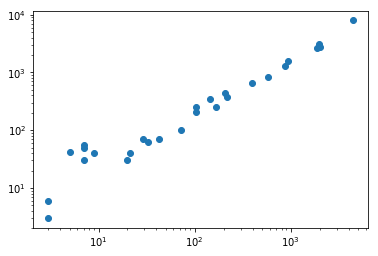

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.loglog(all_counts.iloc[:, 0], all_counts.iloc[:, 1], linewidth=0, marker='o')

In [49]:
# correlate
from scipy.stats import pearsonr
pearsonr(all_counts.iloc[:, 0], all_counts.iloc[:, 1])

(0.9921319998356768, 5.380647269135042e-25)

## Stitch fields of view

In [91]:
len(decoded_intensities)

16

In [80]:
img = exp['fov_000'].primary_image

In [82]:
fov = exp['fov_000']

In [ ]:
# how to stitch together? Assume that things were registered as promised, then all we should need to do is concatenate them, with an adjustment for x, y, z

In [23]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac
%matplotlib inline

# generate synthetic checkerboard image and add gradient for the later matching
img_orig = np.zeros(list(test_image.shape) + [3])
img_orig[..., 0] = test_image
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig = rescale_intensity(img_orig)
img_orig_gray = rgb2gray(img_orig)

# warp synthetic image
tform = AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
img_warped = warp(img_orig, tform.inverse) #, output_shape=(200, 200))
img_warped_gray = rgb2gray(img_warped)

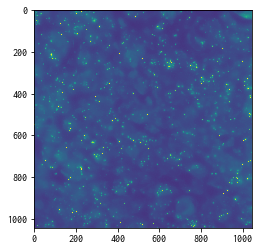

In [24]:
plt.imshow(test_image)

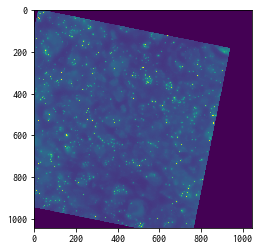

In [25]:
plt.imshow(img_warped_gray)

In [26]:
# extract corners using Harris' corner measure
coords_orig = corner_peaks(corner_harris(img_orig_gray), threshold_rel=0.001,
                           min_distance=5)
coords_warped = corner_peaks(corner_harris(img_warped_gray),
                             threshold_rel=0.001, min_distance=5)

# determine sub-pixel corner position
coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
                                     window_size=9)


def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r_, c_ = np.round(coord).astype(np.intp)
    window_orig = img_orig[r_-window_ext:r_+window_ext+1,
                           c_-window_ext:c_+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    try:
        src.append(coord)
        dst.append(match_corner(coord))
    except: 
        pass
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
print(tform.scale, tform.translation, tform.rotation)
print(model.scale, model.translation, model.rotation)
print(model_robust.scale, model_robust.translation, model_robust.rotation)

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()

/Users/ajc/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in long_scalars
/Users/ajc/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in long_scalars


ValueError: operands could not be broadcast together with shapes (738,) (763,) 

In [9]:
from skimage import img_as_float32

def load_image_stack(fov_num):
    
    # select fov
    ims = glob(os.path.join(im_path, '*.npy'))
    im = np.load([i for i in ims if str(fov_num) in i][0])   
    
    stack = np.zeros((1, 1, 45, 2048, 2048), dtype=np.float32)
    stack[0,0,:,:,:] = img_as_float32(im)

    return ImageStack.from_numpy_array(stack)

In [ ]:
data = img_as_float32(im.reshape(1, 1, *im.shape))  # add ch, hyb 
ImageStack.from_numpy_array(stack)